<a href="https://colab.research.google.com/github/andreytsimbalov/News_Classification_and_Vectorization/blob/main/Classifier_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [9]:
from google.colab import drive
drive.mount('/content/drive')

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

Mounted at /content/drive


In [10]:
import sklearn.cluster as sc
import gensim
import random
import pandas as pd
import numpy as np
import time
import datetime
import pickle
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt


In [11]:
main_tags_list = ['economy',
 'entertainment',
 'traditions',
 'science',
 'society',
 'sports',
 'technology']

main_tags_dict = {0: 'economy',
 1: 'entertainment',
 2: 'traditions',
 3: 'science',
 4: 'society',
 5: 'sports',
 6: 'technology'}

# Извлечение данных для обучения


In [ ]:
def load_data_to_list_of_dict(path):
  # path to lemm/stem data

  df  = pd.read_pickle(path)
  label = df.label.to_numpy()
  try:
    text = df.text.to_numpy()
  except:
    text = df.main_text.to_numpy()
    print('text = main_text')

  return [{"id": i,"label": l,"text": t, } for i, l, t in zip(range(len(label)),label,text) if l!=-1]

path = md + 'data/data_lemm'
# path = md + 'data/news_main_2020'
# path = md + 'data/data_stem'
data_text = load_data_to_list_of_dict(path)
len(data_text), data_text[4]

(69955,
 {'id': 6,
  'label': 1,
  'text': 'лоза отреагировать критика концерт пугачёв композитор юрий лоза интервью риа новость крым прокомментировать критика концерт алла пугачёв заявить телезритель должный право выбор ранее музыкальный критик сергей соседов признаться рад возвращение сцена ряд исполнитель привести пример алла пугачёв софия ротару николай носков назвать выступление печальный зрелище подчеркнуть примадонна еле дышать стоить сцена лоза встать защита российский артист отметить мир должный цветной человек хотеть видеть этот артист должный видеть тот хотеть мочь смотреть должный разный телепередача каждый житель страна мочь выбрать желаемый рассказать композитор композитор добавить возраст исполнитель иметь значение мнение важно форма находиться артист разница сколько мирей матья граница чувствовать свой ветеран который собирать стадион считать певец апрель прошедшее год государственный кремлёвский дворец состояться первый десять год сольный концерт алла пугачёв p.s. кото

In [ ]:
def data_tr_ts_shaffle(data, koeff = 0.2, random_seed = 42):
  # разбиение всего датасета data на 
  #   тренировочную и тестовую выборки с
  #   коеффициентом koeff

  random.seed(random_seed)

  data = [d for d in data if d['label']!=-1]
  random.shuffle(data)

  data_tr_idx=[]
  data_ts_idx=[]

  data_tr=[]
  data_ts=[]

  tags = [d["label"] for d in data]
  mtv = np.zeros(len(main_tags_list))

  for d in data:
    mtv[d['label']]+=1
  mtv_ts = np.zeros(len(mtv))

  for i, d in enumerate(data):
    now_tag = d['label']
    if mtv_ts[now_tag] < koeff * mtv[now_tag]:
      data_ts_idx.extend([i])
    else:
      data_tr_idx.extend([i])

    mtv_ts[now_tag]+=1

  random.shuffle(data_tr_idx)
  random.shuffle(data_ts_idx)
  data_tr = [data[i] for i in data_tr_idx]
  data_ts = [data[i] for i in data_ts_idx]
  data_tr_idx = [data[i]['id'] for i in data_tr_idx]
  data_ts_idx = [data[i]['id'] for i in data_ts_idx]

  return data_tr, data_tr_idx, data_ts, data_ts_idx

# data_train, data_test = data_tr_ts_shaffle(data_text_bal_tfidf, 0.2) 
# len(data_train), len(data_test) 

In [ ]:
def balancing_classes_data(X, more_less = True, koeff_len = 0.5, return_indexes = False):
  # more_less = True -> баленсировка вверх
  # more_less = False -> баленсировка вниз

  X = [d for d in X if d['label']!=-1]

  labels = [news["label"] for news in X]
  un = np.unique(labels)
  un_tags_dict = dict(zip(un, np.zeros(len(un))))
  for i in X:
    un_tags_dict[i["label"]]+=1

  if more_less:
    normal_un_len = 0
    for u in un:
      if un_tags_dict[u]>normal_un_len:
        normal_un_len = un_tags_dict[u]
  else:
    normal_un_len =  un_tags_dict[un[0]]
    for u in un:
      if un_tags_dict[u]<normal_un_len:
        normal_un_len = un_tags_dict[u]

  new_dtr=[]
  new_dtr_indexes=[]

  if more_less:
    normal_un_len = normal_un_len * koeff_len
    for x_i in X:
      new_dtr_indexes+=[x_i['id']]
      if un_tags_dict[x_i["label"]]<normal_un_len:
        for _ in range(int(normal_un_len//un_tags_dict[x_i["label"]])):
          new_dtr_indexes+=[x_i['id']]

  else:
    normal_un_len = normal_un_len / koeff_len
    un_tags_count_less = dict(zip(un, np.zeros(len(un))))
    for i, x_i in enumerate(X):
      if un_tags_count_less[x_i["label"]]<normal_un_len:
        un_tags_count_less[x_i["label"]]+=1
        new_dtr_indexes+=[i]
  print(f'normal_un_len: {normal_un_len}')
  
  random.shuffle(new_dtr_indexes)

  new_dtr = [X[i] for i in new_dtr_indexes]
  new_dtr_indexes = [X[i]['id'] for i in new_dtr_indexes]

  return new_dtr, new_dtr_indexes

# data_text_bal_tfidf = balancing_classes_data(data_text_tfidf, False, 0.7)
# len(data_text_bal_tfidf)

In [ ]:
data_train, data_train_idx, data_test, data_test_idx = data_tr_ts_shaffle(data_text, 0.2) 

more_less = False # True -> Up; False -> Down
koeff_balance = 1
data_train, data_train_idx = balancing_classes_data(data_train, more_less, koeff_balance)
data_test, data_test_idx = balancing_classes_data(data_test, more_less, koeff_balance)
print(len(data_train), len(data_test))

X_train_text = [d['text'] for d in data_train]
X_test_text = [d['text'] for d in data_test]

y_train = [d['label'] for d in data_train]
y_test = [d['label'] for d in data_test]
data_train[:5]

normal_un_len: 3876.0
normal_un_len: 969.0
27132 6783


[{'id': 94022,
  'label': 1,
  'text': 'ефремов предложить сдать анализ запах алкоголь суд бывший адвокат михаил ефремов эльман пашаев предложить организовать сдача анализ актёр подсудимый обвинить запах алкоголь заседание пятница число август сообщать тасс бессовестный человек говорить ефрем употреблять заявить пашаев ответ слово артист пахнуть спиртное ранее ефрем заявить суд отказываться услуга пашаев партнёр елизавета шаргородской затем адвокат попасть видео запечатлеть удивление решение артист вечером число июнь михаил ефрем состояние алкогольный опьянение устроить смертельный авария центр москва автомобиль актёр вылететь встречный полоса столкнуться фургон водитель который сергей захаров скончаться больница ефрем заявить помнить произойти '},
 {'id': 14143,
  'label': 4,
  'text': 'вор закон пухлый пузырь завести дело лидерство преступный мир число_возраст вор закон владимир жураковский известный криминальный круг пухлый ровесник хизира акбулатов кличка пузырь завести уголовный д

# График длин документов

In [ ]:
max_sent_len = 0
for text_i in tqdm([d['text'] for d in data_text]):
  now_len = len(text_i.split())
  max_sent_len = max(max_sent_len, now_len)
max_sent_len

3705

In [ ]:
lens = [len(text_i.split()) for text_i in [d['text'] for d in data_text]]
lens.sort()
lens = np.array(lens)
len(lens[lens>500])/len(lens)

0.0

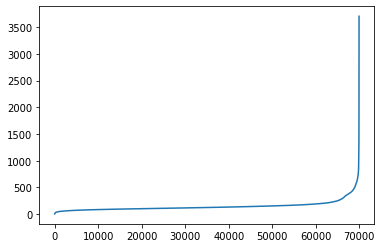

In [ ]:
plt.plot(lens)
plt.show()

In [ ]:
len(lens[lens>512])/len(lens)

0.013337145307697806

# Векторизаторы

## w2v классификация модели

In [ ]:
X_vectors = pickle.load(open(md+"models/w2v_tfidf_vector_data.pickle", "rb"))

In [ ]:
X_train = [X_vectors[i] for i in data_train_idx]
X_test = [X_vectors[i] for i in data_test_idx]
del X_vectors
len(X_train), len(X_test)

(27132, 6783)

## d2v классификация модели

In [ ]:
d2v = gensim.models.Doc2Vec.load(md+"models/d2v_300.model")

In [ ]:
X_train = [d2v.infer_vector(text) for text in tqdm(X_train_text)]
X_test = [d2v.infer_vector(text) for text in tqdm(X_test_text)]

## ft классификация модели

In [ ]:
ft = gensim.models.FastText.load(md+"models/ft_lemm_300.model")

In [ ]:
X_train = [ft.wv[text] for text in tqdm(X_train_text)]
X_test = [ft.wv[text] for text in tqdm(X_test_text)]

## tfidf классификация модели

In [ ]:
# tfidf_path = 'tfidf_lemm'
# tfidf_path = 'tfidf_lemm_100k'
tfidf_path = 'tfidf_lemm_500k'
tfidf = pickle.load(open(md+"models/"+tfidf_path+".pickle", "rb"))

In [ ]:
X_train = tfidf.transform(X_train_text)
X_test = tfidf.transform(X_test_text)
X_test.shape

(6783, 500000)

## glove классификация модели

In [ ]:
X_vectors = pickle.load(open(md+"models/glove_tfidf_vector_data.pickle", "rb"))

In [ ]:
X_train = [X_vectors[i] for i in data_train_idx]
X_test = [X_vectors[i] for i in data_test_idx]
del X_vectors
len(X_train), len(X_test)

(27132, 6783)

In [ ]:
len(data_train_idx) == len(X_train)

True

## Sent Bert кдассификация

In [ ]:
X_vectors = pickle.load(open(md+"models/bert_vector_data.pickle", "rb"))

In [ ]:
X_train = [X_vectors[i] for i in data_train_idx]
X_test = [X_vectors[i] for i in data_test_idx]
del X_vectors
len(X_train), len(X_test)

(27132, 6783)

## USE классификация

In [5]:
X_vectors = pickle.load(open(md+"models/use_vector_data.pickle", "rb"))

NameError: ignored

In [ ]:
X_train = [X_vectors[i] for i in data_train_idx]
X_test = [X_vectors[i] for i in data_test_idx]
del X_vectors
len(X_train), len(X_test)

(27132, 6783)

# LogisticRegression & LinearSVC

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score as cvs
from sklearn import metrics

LinearSVC

In [ ]:
clf = LinearSVC(C = 0.6, random_state = 42)
%time clf.fit(X_train, y_train) # [:1000]
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))

CPU times: user 4.85 s, sys: 45.1 ms, total: 4.9 s
Wall time: 4.88 s
0.8752764263600177
0.8875497567448032


In [ ]:
predicted_lr = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted_lr, target_names = main_tags_list, digits = 6))

               precision    recall  f1-score   support

      economy   0.827381  0.860681  0.843703       969
entertainment   0.824876  0.855521  0.839919       969
   traditions   0.816703  0.777090  0.796404       969
      science   0.845545  0.881321  0.863062       969
      society   0.803445  0.818369  0.810838       969
       sports   0.946930  0.939112  0.943005       969
   technology   0.771910  0.708978  0.739107       969

     accuracy                       0.834439      6783
    macro avg   0.833827  0.834439  0.833720      6783
 weighted avg   0.833827  0.834439  0.833720      6783



LogisticRegression

In [ ]:
clf = LogisticRegression(n_jobs=-1, random_state=42)#,class_weight='balanced'
%time clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.score(X_train, y_train))

CPU times: user 186 ms, sys: 85.2 ms, total: 272 ms
Wall time: 13.9 s
0.8674627745835176
0.8778564057201829


In [ ]:
predicted_lr = clf.predict(X_test)
# predicted_lr_pr = clf.predict_proba(X_test_idf)
# maxes = np.max(predicted_lr_pr, axis=1)
# predicted_lr = np.where(maxes>0.45, predicted_lr, np.ones(len(predicted_lr))*10)
print(metrics.classification_report(y_test, predicted_lr, target_names = main_tags_list, digits = 6))

               precision    recall  f1-score   support

      economy   0.769833  0.811146  0.789950       969
entertainment   0.773227  0.798762  0.785787       969
   traditions   0.742077  0.700722  0.720807       969
      science   0.830052  0.826625  0.828335       969
      society   0.741483  0.763674  0.752415       969
       sports   0.931109  0.892673  0.911486       969
   technology   0.664570  0.654283  0.659386       969

     accuracy                       0.778269      6783
    macro avg   0.778907  0.778269  0.778309      6783
 weighted avg   0.778907  0.778269  0.778309      6783



confusion_matrix

In [ ]:
print(str(clf)[:20])
a = np.array(main_tags_list)
b = metrics.confusion_matrix(y_test,clf.predict(X_test))
pd.DataFrame(data=b,index = a,columns=a)

LinearSVC(C=0.6, cla


,economy,entertainment,traditions,science,society,sports,technology
economy,878,3,30,10,33,3,12
entertainment,3,859,30,6,21,3,47
traditions,22,20,848,25,25,1,28
science,12,2,9,901,17,0,28
society,38,25,20,27,823,4,32
sports,0,6,0,0,5,954,4
technology,26,65,27,53,42,7,749


# Single-layer perceptron

https://realpython.com/python-keras-text-classification/

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_tr = np_utils.to_categorical(encoded_Y)
encoded_Y_ts = encoder.fit_transform(y_test)
y_ts = np_utils.to_categorical(encoded_Y_ts)
print(y_tr.shape)
y_tr[-1], y_ts[-1]

(27132, 7)


(array([0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0.], dtype=float32))

In [ ]:
# for w2v+tfidf; glove+tfidf; d2v; ft; use; bert
x_tr = np.array(X_train).astype('float16')
x_ts = np.array(X_test).astype('float16')
input_dim = len(x_tr[0])

In [ ]:
# for thidf
x_tr = X_train.astype('float16')
x_ts = X_test.astype('float16')
input_dim = x_tr.shape[1]

In [ ]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(main_tags_list), activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# model.summary()

In [ ]:
%time history = model.fit(x_tr, y_tr, epochs=15,validation_data=(x_ts,y_ts))

Epoch 1/15
848/848 [==============================] - 3s 3ms/step - loss: 1.2778 - accuracy: 0.6166 - val_loss: 0.5210 - val_accuracy: 0.8367
Epoch 2/15
848/848 [==============================] - 2s 2ms/step - loss: 0.5498 - accuracy: 0.8224 - val_loss: 0.4484 - val_accuracy: 0.8530
Epoch 3/15
848/848 [==============================] - 2s 2ms/step - loss: 0.4779 - accuracy: 0.8452 - val_loss: 0.4202 - val_accuracy: 0.8589
Epoch 4/15
848/848 [==============================] - 2s 2ms/step - loss: 0.4423 - accuracy: 0.8521 - val_loss: 0.4081 - val_accuracy: 0.8650
Epoch 5/15
848/848 [==============================] - 2s 2ms/step - loss: 0.4197 - accuracy: 0.8600 - val_loss: 0.3937 - val_accuracy: 0.8683
Epoch 6/15
848/848 [==============================] - 2s 2ms/step - loss: 0.4028 - accuracy: 0.8639 - val_loss: 0.3873 - val_accuracy: 0.8688
Epoch 7/15
848/848 [==============================] - 2s 2ms/step - loss: 0.3921 - accuracy: 0.8711 - val_loss: 0.3827 - val_accuracy: 0.8719
Epoch 

In [ ]:
loss, accuracy = model.evaluate(x_ts, y_ts, verbose=False)
print("Testing Accuracy:  {:.6f}".format(accuracy))
loss, accuracy = model.evaluate(x_tr, y_tr, verbose=False)
print("Training Accuracy: {:.6f}".format(accuracy))

Testing Accuracy:  0.793012
Training Accuracy: 0.798467


In [ ]:
from sklearn import metrics

y_pred = model.predict(x_ts)
predicted_lr = np.argmax(y_pred, axis = 1)

print(metrics.classification_report(y_test, predicted_lr, target_names = main_tags_list, digits = 6))

               precision    recall  f1-score   support

      economy   0.774006  0.823529  0.798000       969
entertainment   0.764652  0.861713  0.810286       969
   traditions   0.842681  0.635707  0.724706       969
      science   0.791474  0.881321  0.833984       969
      society   0.716592  0.824561  0.766795       969
       sports   0.932782  0.930857  0.931818       969
   technology   0.748698  0.593395  0.662061       969

     accuracy                       0.793012      6783
    macro avg   0.795841  0.793012  0.789664      6783
 weighted avg   0.795841  0.793012  0.789664      6783



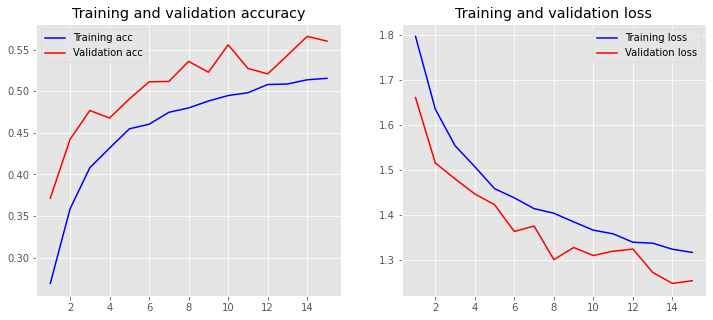

In [ ]:
plot_history(history)

# Подготовка данных Bert

In [ ]:
import gc
df = pd.read_pickle(md+'data/news_main_prepr_2020')
data_lists = []

# for i,t,l in tqdm(zip(df.index, df['lemm_text'], df['label'])):
#   data_lists.append({'id' : , 'text' : t, 'label' : l})
for i,t,l in tqdm(zip(df.index, df['lemm_text'], df['label'])):
  data_lists.append({'id' : i, 'text' : t, 'label' : l})

# print(getsizeof(df))
del df
gc.collect()

11

In [ ]:
data_train, data_train_idx, data_test, data_test_idx = data_tr_ts_shaffle(data_lists, 0.2) 

more_less = False # True -> Up; False -> Down
data_train, data_train_idx = balancing_classes_data(data_train, more_less, 1)
data_test, data_test_idx = balancing_classes_data(data_test, more_less, 1)
print(len(data_train), len(data_test))


3876.0
969.0
27132 6783


In [ ]:
def sent_labeling(data):
  res = []
  for d in tqdm(data):
    for t_i in d['text']:
      text = ''
      for tl_i in t_i:
        text+=' '+tl_i
      res.append({'label': d['label'], 'text': text})
  return res

In [ ]:
data_train = sent_labeling(data_train)
data_test = sent_labeling(data_test)
len(data_train), len(data_test)

(379940, 96167)

In [ ]:
X_train_text = [d['text'] for d in data_train]
X_test_text = [d['text'] for d in data_test]

y_train = [d['label'] for d in data_train]
y_test = [d['label'] for d in data_test]

In [ ]:
del data_train
del data_test
del data_lists
del data_train_idx
del data_test_idx
gc.collect()

544220

In [ ]:
gc.collect()

239

# Bert tests

In [ ]:
# without tokenizer

!pip install transformers

from transformers import TFBertForSequenceClassification
import tensorflow as tf

num_classes = len(main_tags_list)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=num_classes)

In [ ]:
# with tokenizer

!pip install transformers

from transformers import *
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
import tensorflow as tf

num_classes = len(main_tags_list)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased", do_lower_case = True)
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased',num_labels=num_classes)

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# Found GPU at: /device:GPU:0

Found GPU at: /device:GPU:0


## tokenizer

In [ ]:
def prepare_text_for_bert(data_text, max_len = 512):
  max_len = min(max_len, 512)
  input_ids=[]
  attention_masks=[]
  for dt in tqdm(data_text):
      sent = dt
      bert_inp=bert_tokenizer.encode_plus(sent, \
                                          add_special_tokens = True,\
                                          max_length =max_len,\
                                          pad_to_max_length = True,
                                          return_attention_mask = True)
      input_ids.append(bert_inp['input_ids'])
      attention_masks.append(bert_inp['attention_mask'])

  input_ids=np.asarray(input_ids)
  attention_masks=np.asarray(attention_masks)
  return input_ids, attention_masks

max_len = 512

In [ ]:
test_ids, test_mask = prepare_text_for_bert(X_test_text, max_len)
del X_test_text
len(test_ids[0]), len(test_mask[0]), len(test_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(512, 512, 6783)

In [ ]:
train_ids, train_mask = prepare_text_for_bert(X_train_text,max_len)
del X_train_text
len(train_ids[0]), len(train_mask[0]), len(train_mask)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


(512, 512, 27132)

In [ ]:
gc.collect()

0

In [ ]:
#_without_prepr
pickle.dump(test_ids, open(md+"data/bert_tokens/test_ids_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(test_mask, open(md+"data/bert_tokens/test_mask_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(train_ids, open(md+"data/bert_tokens/train_ids_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(train_mask, open(md+"data/bert_tokens/train_mask_down_1_joint_512_without_prepr.pickle", "wb"))

In [ ]:
pickle.dump(y_test, open(md+"data/bert_tokens/y_test_down_1_joint_512_without_prepr.pickle", "wb"))
pickle.dump(y_train, open(md+"data/bert_tokens/y_train_down_1_joint_512_without_prepr.pickle", "wb"))

## train_prepare

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def tensor_encoder(input_ids_list, attention_mask_list, label_list, top_len = -1):
  token_type_ids_list = [[0]*len(input_ids_list[0])]*len(input_ids_list)
  if top_len==-1:
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)
  else:
    return tf.data.Dataset.from_tensor_slices((input_ids_list[:top_len], attention_mask_list[:top_len], token_type_ids_list[:top_len], label_list[:top_len])).map(map_example_to_dict)


In [12]:
#_without_prepr
test_ids = pickle.load(open(md+"data/bert_tokens/test_ids_down_1_joint_512_without_prepr.pickle", "rb"))
test_mask = pickle.load(open(md+"data/bert_tokens/test_mask_down_1_joint_512_without_prepr.pickle", "rb"))
train_ids = pickle.load(open(md+"data/bert_tokens/train_ids_down_1_joint_512_without_prepr.pickle", "rb"))
train_mask = pickle.load(open(md+"data/bert_tokens/train_mask_down_1_joint_512_without_prepr.pickle", "rb"))

In [ ]:
y_test = pickle.load(open(md+"data/bert_tokens/y_test_down_1_joint_512_without_prepr.pickle", "rb"))
y_train = pickle.load(open(md+"data/bert_tokens/y_train_down_1_joint_512_without_prepr.pickle", "rb"))

In [ ]:
len(y_train)

27132

In [23]:
counter = 0

for tm in train_mask:
  if tm[-1]==0:
    counter+=1

counter/len(train_mask)

0.8008993070912576

In [ ]:
# use for SparseCategoricalCrossentropy

y_test = [[l] for l in y_test]
y_train = [[l] for l in y_train]

In [ ]:
# use for CategoricalCrossentropy

from keras.utils import np_utils
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_tr = np_utils.to_categorical(encoded_Y)
encoded_Y_ts = encoder.fit_transform(y_test)
y_ts = np_utils.to_categorical(encoded_Y_ts)
y_tr.shape

(27132, 7)

In [ ]:
y_test = y_ts
y_train = y_tr

In [ ]:
y_train[0], y_tr[0]

(array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0., 0.], dtype=float32))

## train


In [ ]:
# SparseCategoricalCrossentropy
model = bert_model

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# metric = tf.keras.metrics.SparseCategoricalCrossentropy('accuracy')# categorical_crossentropy accuracy
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
# CategoricalCrossentropy
model = bert_model

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 
# metric = tf.keras.metrics.SparseCategoricalCrossentropy('accuracy')# categorical_crossentropy accuracy
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
batch_size = 8
top_numder = -1
top_test = top_numder
top_train = top_numder
ds_test_encoded = tensor_encoder(test_ids, test_mask, y_test, top_test).batch(batch_size)
ds_train_encoded = tensor_encoder(train_ids, train_mask, y_train, top_train).batch(batch_size)

history=model.fit(
    ds_train_encoded,
    epochs=5,
    validation_data=ds_test_encoded)

Epoch 1/5
3392/3392 [==============================] - 3671s 1s/step - loss: 0.3727 - accuracy: 0.8834 - val_loss: 0.2569 - val_accuracy: 0.9163
Epoch 2/5
3392/3392 [==============================] - 3672s 1s/step - loss: 0.1981 - accuracy: 0.9365 - val_loss: 0.2951 - val_accuracy: 0.9170
Epoch 3/5
3392/3392 [==============================] - 3672s 1s/step - loss: 0.1364 - accuracy: 0.9564 - val_loss: 0.3137 - val_accuracy: 0.9204
Epoch 4/5
3392/3392 [==============================] - 3669s 1s/step - loss: 0.0989 - accuracy: 0.9693 - val_loss: 0.2936 - val_accuracy: 0.9254
Epoch 5/5
3392/3392 [==============================] - 3671s 1s/step - loss: 0.0803 - accuracy: 0.9751 - val_loss: 0.3114 - val_accuracy: 0.9264


In [ ]:
from sklearn import metrics

y_pred = model.predict(ds_test_encoded)
predicted_lr = np.argmax(y_pred[0], axis = 1)

print(metrics.classification_report(y_test, predicted_lr, target_names = main_tags_list, digits = 6))

               precision    recall  f1-score   support

      economy   0.966396  0.860681  0.910480       969
entertainment   0.966704  0.898865  0.931551       969
   traditions   0.853480  0.961816  0.904415       969
      science   0.904215  0.974200  0.937904       969
      society   0.937500  0.882353  0.909091       969
       sports   0.972700  0.992776  0.982635       969
   technology   0.902240  0.914345  0.908252       969

     accuracy                       0.926434      6783
    macro avg   0.929033  0.926434  0.926333      6783
 weighted avg   0.929033  0.926434  0.926333      6783



In [ ]:
model.save(md+"models/bert_classifier")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Diplom/models/bert_classifier/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Diplom/models/bert_classifier/assets


# GPT


In [ ]:
!pip install transformers

In [ ]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer, 
    TFGPT2ForSequenceClassification, 
    GPT2ForSequenceClassification)

In [ ]:
model_path = 'sberbank-ai/rugpt3medium_based_on_gpt2'

model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_path, num_labels=7)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
gpt_model = GPT2ForSequenceClassification.from_pretrained(model_path, config=model_config)
model = gpt_model

Some weights of the model checkpoint at sberbank-ai/rugpt3medium_based_on_gpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/rugpt3medium_based_on_gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## classes creator

In [ ]:
!pip install -q git+https://github.com/gmihaila/ml_things.git

In [ ]:
import io
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


In [ ]:
set_seed(123)
epochs = 4
batch_size = 8
max_length = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name_or_path = 'gpt2'
labels_ids = dict(zip(list(main_tags_dict.keys()), list(main_tags_dict.keys())))
n_labels = len(labels_ids)
n_labels = len(main_tags_list)
n_labels

7

In [ ]:
tokenizer.padding_side = "left"
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)
print('Model loaded to `%s`'%device)

Model loaded to `cuda`


In [ ]:
class MovieReviewsDataset(Dataset):
  

  def __init__(self, data_text, data_label, use_tokenizer):

    self.texts = data_text
    self.labels = data_label
    self.n_examples = len(self.labels)
    return

  def __len__(self):
    return self.n_examples

  def __getitem__(self, item):
    return {'text':self.texts[item],
            'label':self.labels[item]}



class Gpt2ClassificationCollator(object):
    

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):

        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  
  global model

  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.train()

  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    model.zero_grad()
    outputs = model(**batch)
    loss, logits = outputs[:2]
    total_loss += loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    logits = logits.detach().cpu().numpy()
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  avg_epoch_loss = total_loss / len(dataloader)
  
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  global model
  predictions_labels = []
  true_labels = []
  total_loss = 0
  model.eval()

  for batch in tqdm(dataloader, total=len(dataloader)):
    true_labels += batch['labels'].numpy().flatten().tolist()
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    with torch.no_grad():        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss += loss.item()
        predict_content = logits.argmax(axis=-1).flatten().tolist()
        predictions_labels += predict_content

  avg_epoch_loss = total_loss / len(dataloader)

  return true_labels, predictions_labels, avg_epoch_loss

In [ ]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

train_dataset = MovieReviewsDataset(
    data_text=X_train_text,
    data_label=y_train, 
    use_tokenizer=tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)

In [ ]:
valid_dataset =  MovieReviewsDataset(
    data_text=X_test_text,
    data_label=y_test, 
    use_tokenizer=tokenizer)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)

## train

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}


In [ ]:
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch



Training on batches...



Validation on batches...



  train_loss: 0.44364 - val_loss: 0.34772 - train_acc: 0.86474 - valid_acc: 0.90373


Training on batches...



Validation on batches...



  train_loss: 0.23186 - val_loss: 0.34805 - train_acc: 0.93521 - valid_acc: 0.91670


Training on batches...



Validation on batches...



  train_loss: 0.11993 - val_loss: 0.42524 - train_acc: 0.96974 - valid_acc: 0.91877


Training on batches...



Validation on batches...



  train_loss: 0.04841 - val_loss: 0.49267 - train_acc: 0.98728 - valid_acc: 0.92378




In [ ]:
from sklearn import metrics

valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
predicted_lr = valid_predict

print(metrics.classification_report(y_test, predicted_lr, target_names = main_tags_list, digits = 6))


               precision    recall  f1-score   support

      economy   0.934021  0.934985  0.934502       969
entertainment   0.925654  0.912281  0.918919       969
   traditions   0.920207  0.916409  0.918304       969
      science   0.926188  0.945304  0.935649       969
      society   0.905920  0.884417  0.895039       969
       sports   0.974593  0.989680  0.982079       969
   technology   0.878850  0.883385  0.881112       969

     accuracy                       0.923780      6783
    macro avg   0.923633  0.923780  0.923658      6783
 weighted avg   0.923633  0.923780  0.923658      6783



/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


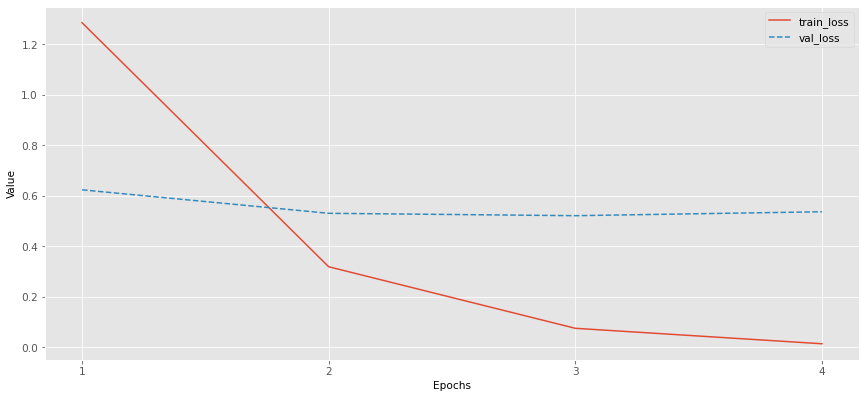

/usr/local/lib/python3.7/dist-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


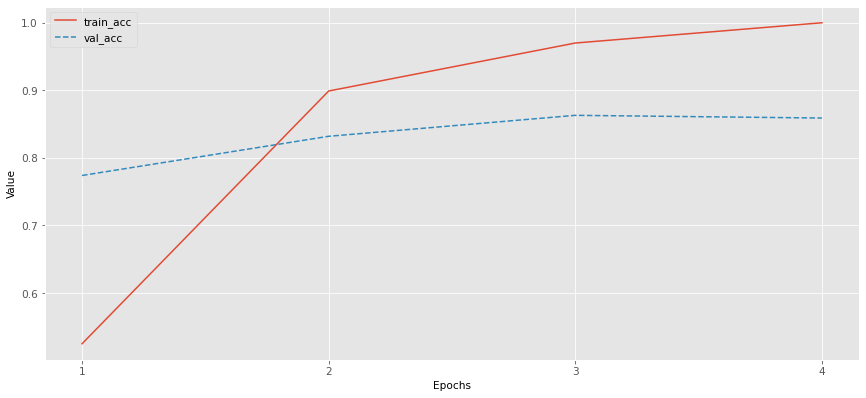

In [ ]:
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])